In [ ]:
from pathlib import Path
import numpy as np, pickle, pandas as pd

ROOT = Path().resolve().parent
DATA = ROOT / "notebooks" / "data"
OUT  = ROOT / "outputs" / "part3"; OUT.mkdir(parents=True, exist_ok=True)

EMB_PATH   = DATA / "w2v_300d_embedding_matrix.npy"
VOCAB_PATH = DATA / "vocab.pkl"
TRAIN_CSV  = DATA / "trec_train.csv"
VAL_CSV    = DATA / "trec_val.csv"
TEST_CSV   = DATA / "trec_test.csv"

assert TRAIN_CSV.exists() and VAL_CSV.exists() and TEST_CSV.exists(), "Put trec_* CSVs in notebooks/data/"

assert EMB_PATH.exists(), "Run Task1 to create w2v_300d_embedding_matrix.npy"
embedding_matrix = np.load(EMB_PATH)
EMBED_DIM = embedding_matrix.shape[1]
print("Embedding:", embedding_matrix.shape)

def load_vocab_strict(path: Path):
    with open(path, "rb") as f:
        obj = pickle.load(f)
    if isinstance(obj, dict) and "stoi" in obj and "itos" in obj:
        return obj["stoi"], obj["itos"]
    if isinstance(obj, dict) and "stoi" in obj and "itos" not in obj:
        stoi = obj["stoi"]
        itos = [None] * (max(stoi.values()) + 1)
        for w,i in stoi.items():
            if i < len(itos): itos[i] = w
        if any(t is None for t in itos):
            pairs = sorted(stoi.items(), key=lambda kv: kv[1])
            itos = [w for w,_ in pairs]
        return stoi, itos
    raise ValueError("vocab.pkl exists but is not in an expected format")

def rebuild_vocab_from_train(train_csv: Path):
    import spacy
    try:
        nlp = spacy.load("en_core_web_sm", disable=["ner","parser","textcat"])
    except Exception:
        nlp = spacy.blank("en")
    from collections import Counter
    PAD_IDX, UNK_IDX = 0, 1
    df = pd.read_csv(train_csv)
    tokfreq = Counter()
    for text in df["text"].tolist():
        doc = nlp(str(text))
        toks = [t.text.lower() for t in doc if not t.is_space]
        tokfreq.update(toks)
    itos = ["<pad>", "<unk>"] + [w for w,_ in tokfreq.items()]
    stoi = {w:i for i,w in enumerate(itos)}
    return stoi, itos

def load_vocab(VOCAB_PATH: Path):
    if VOCAB_PATH.exists():
        try:
            stoi, itos = load_vocab_strict(VOCAB_PATH)
            print("Loaded vocab.pkl (strict).")
            return stoi, itos, "loaded"
        except Exception as e:
            print("vocab.pkl present but not strict:", e)
    print("Rebuilding stoi/itos from TRAIN to match Task1 logic...")
    stoi, itos = rebuild_vocab_from_train(TRAIN_CSV)
    return stoi, itos, "rebuilt"

stoi, itos, vsrc = load_vocab(VOCAB_PATH)

PAD_IDX, UNK_IDX = 0, 1
assert itos[PAD_IDX] == "<pad>" and itos[UNK_IDX] == "<unk>", "PAD/UNK must be <pad>/<unk> at 0/1"
if len(itos) != embedding_matrix.shape[0]:
    raise RuntimeError(
        f"Vocab/embedding mismatch: len(itos)={len(itos)} vs rows={embedding_matrix.shape[0]}.\n"
        "Ensure Task1 and Task3 tokenize the same way and that vocab comes from Task1."
    )

print(f"Vocab source: {vsrc} | size={len(itos)}")


Embedding: (7435, 300)
Rebuilding stoi/itos from TRAIN to match Task1 logic...
Vocab source: rebuilt | size=7435


In [3]:
# Data & labels
train_df = pd.read_csv(TRAIN_CSV)
val_df   = pd.read_csv(VAL_CSV)
test_df  = pd.read_csv(TEST_CSV)

labels = sorted(train_df["label"].unique().tolist())
label2idx = {lab:i for i,lab in enumerate(labels)}
idx2label = {i:lab for lab,i in label2idx.items()}
num_classes = len(labels)
print("Splits:", train_df.shape, val_df.shape, test_df.shape, "| classes:", num_classes, labels)


Splits: (4362, 2) (1090, 2) (500, 2) | classes: 6 ['ABBR', 'DESC', 'ENTY', 'HUM', 'LOC', 'NUM']


In [4]:
# Tokenization (same as Task1)
import spacy
try:
    nlp = spacy.load("en_core_web_sm", disable=["ner","parser","textcat"])
except Exception:
    nlp = spacy.blank("en")

def tokenize(text):
    return [t.text.lower() for t in nlp(str(text)) if not t.is_space]

import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

def encode(text):
    toks = tokenize(text)
    ids  = [stoi.get(t, UNK_IDX) for t in toks]
    return torch.tensor(ids, dtype=torch.long)

class TrecDataset(Dataset):
    def __init__(self, frame):
        self.x = frame["text"].tolist()
        self.y = frame["label"].map(label2idx).astype(int).tolist()
    def __len__(self): return len(self.x)
    def __getitem__(self, i):
        return encode(self.x[i]), torch.tensor(self.y[i], dtype=torch.long)

def collate_fn(batch):
    xs, ys = zip(*batch)
    lengths = torch.tensor([len(x) for x in xs])
    xs_pad  = pad_sequence(xs, batch_first=True, padding_value=PAD_IDX)
    return xs_pad, torch.stack(ys), lengths

BATCH = 64
train_loader = DataLoader(TrecDataset(train_df), batch_size=BATCH, shuffle=True,  collate_fn=collate_fn)
val_loader   = DataLoader(TrecDataset(val_df),   batch_size=BATCH, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(TrecDataset(test_df),  batch_size=BATCH, shuffle=False, collate_fn=collate_fn)


In [5]:
# Models
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class BiRNNClassifier(nn.Module):
    def __init__(self, embedding_matrix, rnn_type="lstm",
                 hidden_dim=128, num_layers=2, bidirectional=True,
                 emb_dropout=0.2, fc_dropout=0.3, agg="last",
                 pad_idx=0, num_classes=6):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(
            torch.from_numpy(embedding_matrix).float(), freeze=False, padding_idx=pad_idx
        )
        self.emb_drop = nn.Dropout(emb_dropout)
        rnn_cls = {"lstm": nn.LSTM, "gru": nn.GRU}[rnn_type]
        self.rnn = rnn_cls(
            input_size=embedding_matrix.shape[1],
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=0.0 if num_layers==1 else 0.2
        )
        self.agg = agg
        out_dim = hidden_dim * (2 if bidirectional else 1)
        self.fc  = nn.Sequential(nn.Dropout(fc_dropout), nn.Linear(out_dim, num_classes))

    def forward(self, x):
        mask    = (x != PAD_IDX)
        lengths = mask.sum(dim=1).cpu()
        emb     = self.emb_drop(self.embedding(x))
        packed  = pack_padded_sequence(emb, lengths, batch_first=True, enforce_sorted=False)
        out, h  = self.rnn(packed)
        out, _  = pad_packed_sequence(out, batch_first=True)
        if self.agg == "last":
            if isinstance(h, tuple): h = h[0]
            sent = torch.cat([h[-2], h[-1]], dim=1) if self.rnn.bidirectional else h[-1]
        elif self.agg == "mean":
            sent = (out * mask.unsqueeze(-1)).sum(1) / lengths.to(out.device).unsqueeze(-1)
        elif self.agg == "max":
            sent = (out + (~mask).unsqueeze(-1) * -1e9).max(dim=1).values
        else:
            raise ValueError("agg must be last|mean|max")
        return self.fc(sent)

class TextCNN(nn.Module):
    def __init__(self, embedding_matrix, num_classes=6, pad_idx=0,
                 filter_sizes=(3,4,5), num_filters=120, emb_dropout=0.2, fc_dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(
            torch.from_numpy(embedding_matrix).float(), freeze=False, padding_idx=pad_idx
        )
        self.emb_drop = nn.Dropout(emb_dropout)
        D = embedding_matrix.shape[1]
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=D, out_channels=num_filters, kernel_size=k)
            for k in filter_sizes
        ])
        self.fc = nn.Sequential(nn.Dropout(fc_dropout),
                                nn.Linear(num_filters * len(filter_sizes), num_classes))

    def forward(self, x):
        emb  = self.emb_drop(self.embedding(x))
        feat = emb.transpose(1, 2)
        pooled = [torch.relu(conv(feat)).max(dim=2).values for conv in self.convs]
        cat = torch.cat(pooled, dim=1)
        return self.fc(cat)

class AttentiveBiLSTM(BiRNNClassifier):
    def __init__(self, *args, attn_dim=128, **kwargs):
        super().__init__(*args, **kwargs)
        out_dim  = self.rnn.hidden_size * (2 if self.rnn.bidirectional else 1)
        self.attn = nn.Sequential(
            nn.Linear(out_dim, attn_dim), nn.Tanh(), nn.Linear(attn_dim, 1)
        )
        self.fc   = nn.Sequential(nn.Dropout(0.3), nn.Linear(out_dim, kwargs.get("num_classes", 6)))
    def forward(self, x):
        mask    = (x != PAD_IDX)
        lengths = mask.sum(dim=1).cpu()
        emb     = self.emb_drop(self.embedding(x))
        packed  = pack_padded_sequence(emb, lengths, batch_first=True, enforce_sorted=False)
        out, _  = self.rnn(packed)
        out, _  = pad_packed_sequence(out, batch_first=True)
        score   = self.attn(out).squeeze(-1)
        score   = score.masked_fill(~mask, -1e9)
        alpha   = torch.softmax(score, dim=1)
        sent    = torch.bmm(alpha.unsqueeze(1), out).squeeze(1)
        return self.fc(sent)


In [6]:
# Train/eval utils
import torch
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

def run_epoch(model, loader, optimizer=None, class_weights=None):
    model.train() if optimizer is not None else model.eval()
    crit = torch.nn.CrossEntropyLoss(weight=class_weights.to(model.embedding.weight.device) if class_weights is not None else None)
    total, correct, total_loss = 0, 0, 0.0
    for x, y, lengths in loader:
        x, y = x.to(model.embedding.weight.device), y.to(model.embedding.weight.device)
        if optimizer is not None: optimizer.zero_grad()
        logits = model(x); loss = crit(logits, y)
        if optimizer is not None: loss.backward(); optimizer.step()
        total_loss += float(loss) * y.size(0)
        correct    += (logits.argmax(1) == y).sum().item()
        total      += y.size(0)
    return total_loss/total, correct/total

def train_model(model, train_loader, val_loader, epochs=20, lr=1e-3, wd=1e-4,
                class_weights=None, patience=8, tag="model"):
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(DEVICE)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    best_val, best_state = 0.0, None
    hist = []; noimp = 0
    for ep in range(1, epochs+1):
        tr_loss, tr_acc = run_epoch(model, train_loader, opt, class_weights)
        vl_loss, vl_acc = run_epoch(model, val_loader, None, None)
        hist.append((ep, tr_loss, tr_acc, vl_loss, vl_acc))
        print(f"[{tag}] Ep {ep:02d} | train {tr_acc:.3f} | val {vl_acc:.3f}")
        if vl_acc > best_val + 1e-5:
            best_val, best_state, noimp = vl_acc, {k:v.detach().cpu().clone() for k,v in model.state_dict().items()}, 0
        else:
            noimp += 1
            if noimp >= patience:
                print(f"[{tag}] Early stopping at ep {ep}")
                break
    if best_state is not None: model.load_state_dict(best_state)
    hist_df = pd.DataFrame(hist, columns=["epoch","train_loss","train_acc","val_loss","val_acc"])
    # Plots
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(hist_df["epoch"], hist_df["train_loss"], label="train loss")
    ax.plot(hist_df["epoch"], hist_df["val_loss"],   label="val loss")
    ax.set_xlabel("epoch"); ax.set_ylabel("loss"); ax.legend(); ax.grid(True, alpha=0.3)
    plt.tight_layout(); plt.savefig(OUT/f"loss_{tag}.png", dpi=140); plt.show()
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(hist_df["epoch"], hist_df["train_acc"], label="train acc")
    ax.plot(hist_df["epoch"], hist_df["val_acc"],   label="val acc")
    ax.set_xlabel("epoch"); ax.set_ylabel("accuracy"); ax.legend(); ax.grid(True, alpha=0.3)
    plt.tight_layout(); plt.savefig(OUT/f"acc_{tag}.png", dpi=140); plt.show()
    return model, hist_df

def test_model(model, test_loader, tag="model"):
    _, test_acc = run_epoch(model, test_loader, optimizer=None)
    print(f"[{tag}] TEST acc = {test_acc:.4f}")
    return test_acc

def evaluate_per_class(model, loader, labels, tag="model"):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y, _ in loader:
            logits = model(x.to(next(model.parameters()).device))
            y_pred.extend(logits.argmax(1).cpu().numpy())
            y_true.extend(y.numpy())
    print(f"\n[{tag}] Classification report:")
    print(classification_report(y_true, y_pred, target_names=labels, digits=4))
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(6.5,5))
    im = ax.imshow(cm, interpolation="nearest"); ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(len(labels)), yticks=np.arange(len(labels)),
           xticklabels=labels, yticklabels=labels, ylabel="True", xlabel="Predicted",
           title=f"Confusion Matrix — {tag}")
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha="center", va="center")
    plt.tight_layout(); plt.savefig(OUT/f"cm_{tag}.png", dpi=140); plt.show()

def topic_wise_accuracy(model, loader):
    model.eval(); all_labels, all_preds = [], []
    with torch.no_grad():
        for x, y, _ in loader:
            logits = model(x.to(next(model.parameters()).device))
            all_preds.extend(logits.argmax(1).cpu().numpy())
            all_labels.extend(y.numpy())
    all_labels = np.array(all_labels); all_preds = np.array(all_preds)
    out = {}; topics = np.unique(all_labels)
    for t in topics:
        idx = (all_labels == t)
        out[idx2label[t]] = float(accuracy_score(all_labels[idx], all_preds[idx]))
    out["overall"] = float(accuracy_score(all_labels, all_preds))
    return out


[biLSTM] Ep 01 | train 0.491 | val 0.745
[biLSTM] Ep 02 | train 0.814 | val 0.836
[biLSTM] Ep 03 | train 0.911 | val 0.854
[biLSTM] Ep 04 | train 0.959 | val 0.871
[biLSTM] Ep 05 | train 0.971 | val 0.880
[biLSTM] Ep 06 | train 0.985 | val 0.857
[biLSTM] Ep 07 | train 0.993 | val 0.840
[biLSTM] Ep 08 | train 0.993 | val 0.865
[biLSTM] Ep 09 | train 0.995 | val 0.866
[biLSTM] Ep 10 | train 0.994 | val 0.850
[biLSTM] Ep 11 | train 0.995 | val 0.858
[biLSTM] Ep 12 | train 0.991 | val 0.841
[biLSTM] Ep 13 | train 0.996 | val 0.861
[biLSTM] Early stopping at ep 13


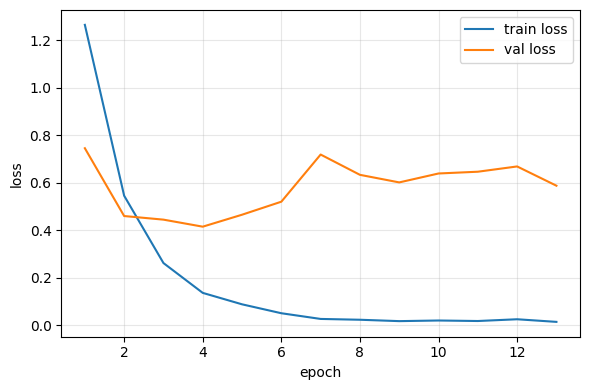

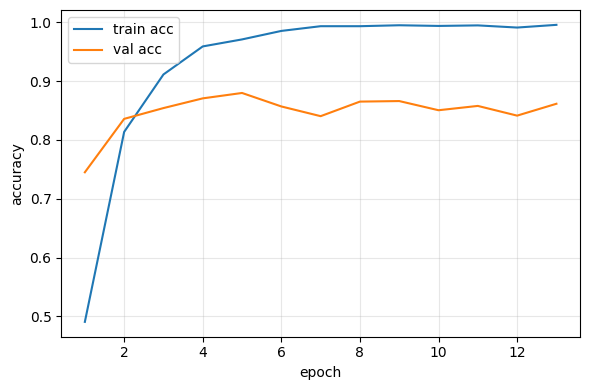

[biLSTM] TEST acc = 0.8940
[biGRU] Ep 01 | train 0.764 | val 0.836
[biGRU] Ep 02 | train 0.966 | val 0.829
[biGRU] Ep 03 | train 0.984 | val 0.835
[biGRU] Ep 04 | train 0.992 | val 0.836
[biGRU] Ep 05 | train 0.998 | val 0.854
[biGRU] Ep 06 | train 0.997 | val 0.830
[biGRU] Ep 07 | train 0.996 | val 0.843
[biGRU] Ep 08 | train 0.994 | val 0.851
[biGRU] Ep 09 | train 0.997 | val 0.846
[biGRU] Ep 10 | train 0.991 | val 0.857
[biGRU] Ep 11 | train 1.000 | val 0.813
[biGRU] Ep 12 | train 0.999 | val 0.861
[biGRU] Ep 13 | train 0.999 | val 0.863
[biGRU] Ep 14 | train 1.000 | val 0.859
[biGRU] Ep 15 | train 1.000 | val 0.860
[biGRU] Ep 16 | train 0.999 | val 0.858
[biGRU] Ep 17 | train 0.999 | val 0.853
[biGRU] Ep 18 | train 1.000 | val 0.860
[biGRU] Ep 19 | train 1.000 | val 0.852
[biGRU] Ep 20 | train 1.000 | val 0.862


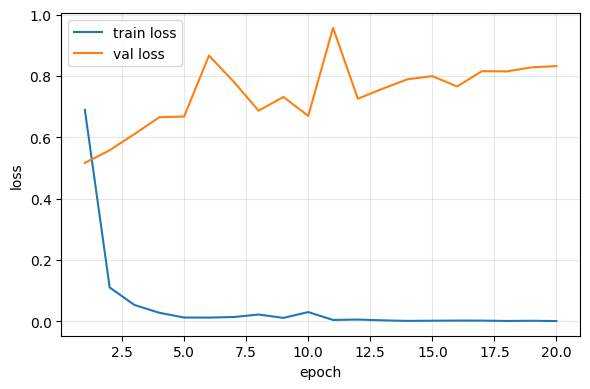

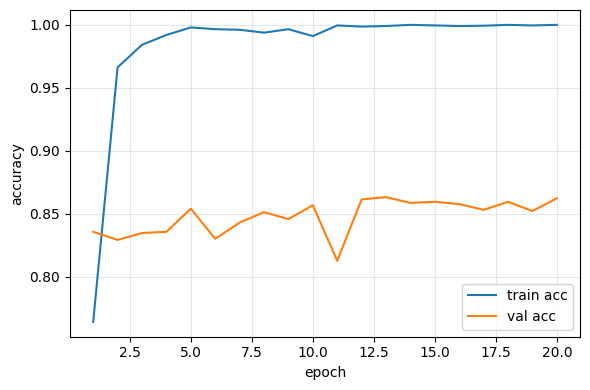

[biGRU] TEST acc = 0.8780
[CNN] Ep 01 | train 0.823 | val 0.850
[CNN] Ep 02 | train 0.977 | val 0.861
[CNN] Ep 03 | train 0.993 | val 0.870
[CNN] Ep 04 | train 0.997 | val 0.866
[CNN] Ep 05 | train 0.998 | val 0.872
[CNN] Ep 06 | train 0.999 | val 0.868
[CNN] Ep 07 | train 1.000 | val 0.869
[CNN] Ep 08 | train 1.000 | val 0.872
[CNN] Ep 09 | train 0.999 | val 0.870
[CNN] Ep 10 | train 1.000 | val 0.862
[CNN] Ep 11 | train 1.000 | val 0.873
[CNN] Ep 12 | train 1.000 | val 0.867
[CNN] Ep 13 | train 1.000 | val 0.873
[CNN] Ep 14 | train 1.000 | val 0.870
[CNN] Ep 15 | train 1.000 | val 0.869
[CNN] Ep 16 | train 1.000 | val 0.869
[CNN] Ep 17 | train 1.000 | val 0.869
[CNN] Ep 18 | train 1.000 | val 0.872
[CNN] Ep 19 | train 1.000 | val 0.869
[CNN] Early stopping at ep 19


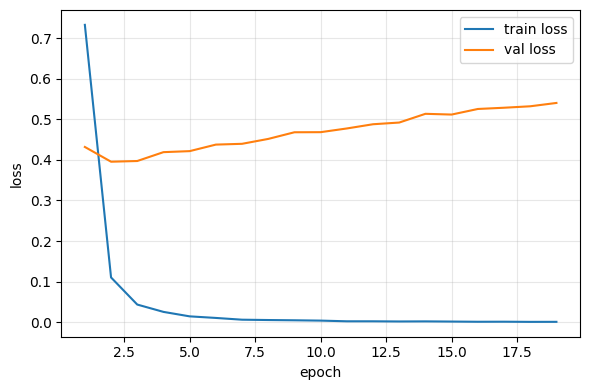

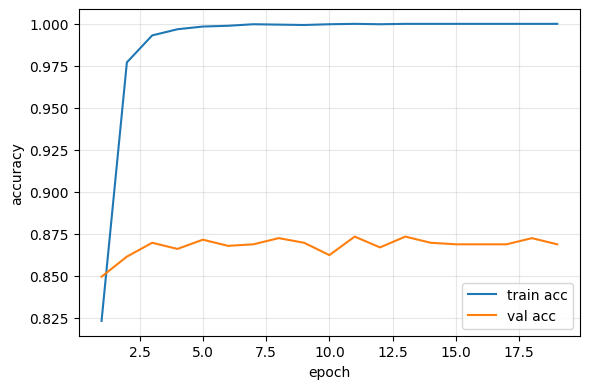

[CNN] TEST acc = 0.9020


,Model,Test Acc
0,biLSTM,0.894
1,biGRU,0.878
2,CNN,0.902


In [7]:
# Baselines
EPOCHS, LR, WD = 20, 1e-3, 1e-4

bilstm = BiRNNClassifier(embedding_matrix, rnn_type="lstm",
                         num_classes=num_classes, pad_idx=PAD_IDX,
                         hidden_dim=128, num_layers=2, agg="last")
bilstm, _ = train_model(bilstm, train_loader, val_loader, epochs=EPOCHS, lr=LR, wd=WD, tag="biLSTM")
acc_bilstm = test_model(bilstm, test_loader, tag="biLSTM")

bigru = BiRNNClassifier(embedding_matrix, rnn_type="gru",
                        num_classes=num_classes, pad_idx=PAD_IDX,
                        hidden_dim=128, num_layers=2, agg="last")
bigru, _ = train_model(bigru, train_loader, val_loader, epochs=EPOCHS, lr=LR, wd=WD, tag="biGRU")
acc_bigru = test_model(bigru, test_loader, tag="biGRU")

cnn = TextCNN(embedding_matrix, num_classes=num_classes, pad_idx=PAD_IDX,
              filter_sizes=(3,4,5), num_filters=120)
cnn, _ = train_model(cnn, train_loader, val_loader, epochs=EPOCHS, lr=LR, wd=WD, tag="CNN")
acc_cnn = test_model(cnn, test_loader, tag="CNN")

pd.DataFrame({"Model":["biLSTM","biGRU","CNN"], "Test Acc":[acc_bilstm, acc_bigru, acc_cnn]})


[AttnBiLSTM] Ep 01 | train 0.804 | val 0.822
[AttnBiLSTM] Ep 02 | train 0.990 | val 0.838
[AttnBiLSTM] Ep 03 | train 0.997 | val 0.835
[AttnBiLSTM] Ep 04 | train 0.994 | val 0.828
[AttnBiLSTM] Ep 05 | train 0.995 | val 0.823
[AttnBiLSTM] Ep 06 | train 0.998 | val 0.837
[AttnBiLSTM] Ep 07 | train 1.000 | val 0.849
[AttnBiLSTM] Ep 08 | train 1.000 | val 0.850
[AttnBiLSTM] Ep 09 | train 1.000 | val 0.841
[AttnBiLSTM] Ep 10 | train 1.000 | val 0.850
[AttnBiLSTM] Ep 11 | train 1.000 | val 0.850
[AttnBiLSTM] Ep 12 | train 1.000 | val 0.849
[AttnBiLSTM] Ep 13 | train 1.000 | val 0.852
[AttnBiLSTM] Ep 14 | train 1.000 | val 0.851
[AttnBiLSTM] Ep 15 | train 1.000 | val 0.852
[AttnBiLSTM] Ep 16 | train 1.000 | val 0.854
[AttnBiLSTM] Ep 17 | train 1.000 | val 0.854
[AttnBiLSTM] Ep 18 | train 1.000 | val 0.854
[AttnBiLSTM] Ep 19 | train 1.000 | val 0.853
[AttnBiLSTM] Ep 20 | train 1.000 | val 0.853


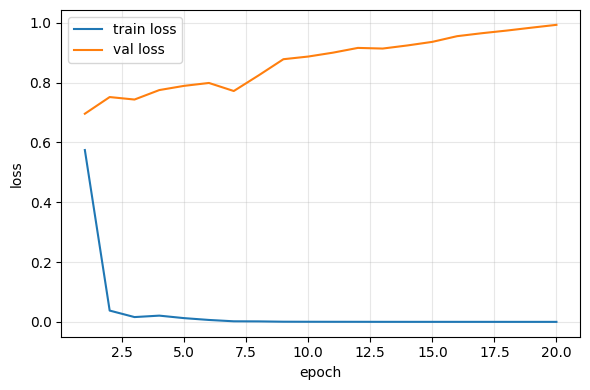

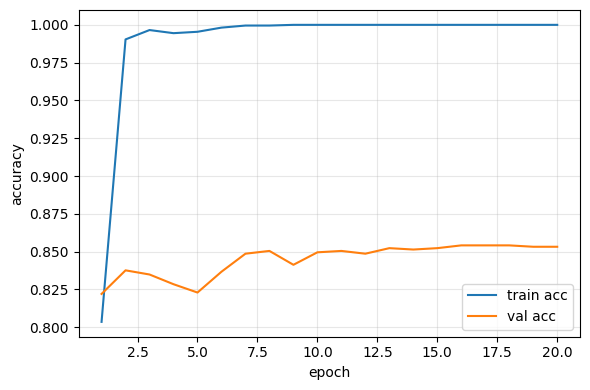

[AttnBiLSTM] TEST acc = 0.8620

[AttnBiLSTM] Classification report:
              precision    recall  f1-score   support

        ABBR     0.5833    0.7778    0.6667         9
        DESC     0.8086    0.9493    0.8733       138
        ENTY     0.8310    0.6277    0.7152        94
         HUM     0.8676    0.9077    0.8872        65
         LOC     0.8810    0.9136    0.8970        81
         NUM     0.9806    0.8938    0.9352       113

    accuracy                         0.8620       500
   macro avg     0.8254    0.8450    0.8291       500
weighted avg     0.8670    0.8620    0.8595       500



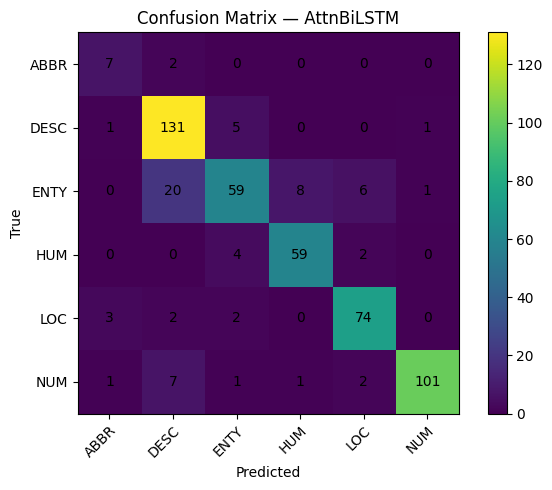

In [8]:
# Enhancement: self-attentive biLSTM
attn_bilstm = AttentiveBiLSTM(embedding_matrix, rnn_type="lstm",
                              num_classes=num_classes, pad_idx=PAD_IDX,
                              hidden_dim=128, num_layers=2)
attn_bilstm, _ = train_model(attn_bilstm, train_loader, val_loader,
                             epochs=EPOCHS, lr=LR, wd=WD, tag="AttnBiLSTM")
acc_attn = test_model(attn_bilstm, test_loader, tag="AttnBiLSTM")
evaluate_per_class(attn_bilstm, test_loader, labels, tag="AttnBiLSTM")


[AttnBiLSTM_weighted] Ep 01 | train 0.822 | val 0.827
[AttnBiLSTM_weighted] Ep 02 | train 0.996 | val 0.833
[AttnBiLSTM_weighted] Ep 03 | train 0.998 | val 0.832
[AttnBiLSTM_weighted] Ep 04 | train 0.996 | val 0.797
[AttnBiLSTM_weighted] Ep 05 | train 0.999 | val 0.840
[AttnBiLSTM_weighted] Ep 06 | train 1.000 | val 0.828
[AttnBiLSTM_weighted] Ep 07 | train 1.000 | val 0.833
[AttnBiLSTM_weighted] Ep 08 | train 1.000 | val 0.823
[AttnBiLSTM_weighted] Ep 09 | train 1.000 | val 0.839
[AttnBiLSTM_weighted] Ep 10 | train 1.000 | val 0.833
[AttnBiLSTM_weighted] Ep 11 | train 1.000 | val 0.840
[AttnBiLSTM_weighted] Ep 12 | train 1.000 | val 0.841
[AttnBiLSTM_weighted] Ep 13 | train 1.000 | val 0.837
[AttnBiLSTM_weighted] Ep 14 | train 1.000 | val 0.839
[AttnBiLSTM_weighted] Ep 15 | train 1.000 | val 0.838
[AttnBiLSTM_weighted] Ep 16 | train 1.000 | val 0.837
[AttnBiLSTM_weighted] Ep 17 | train 1.000 | val 0.837
[AttnBiLSTM_weighted] Ep 18 | train 1.000 | val 0.837
[AttnBiLSTM_weighted] Ep 19 

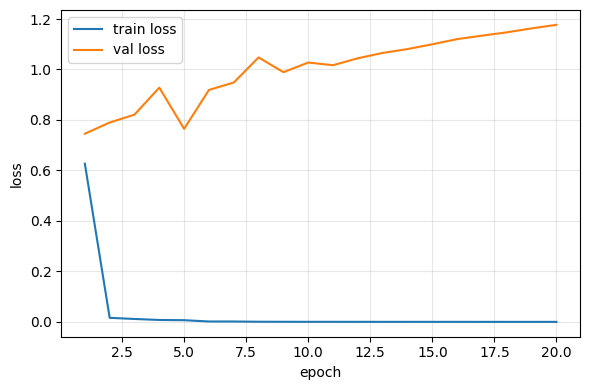

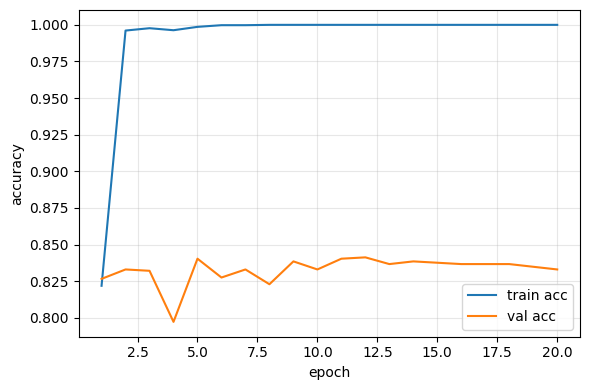

[AttnBiLSTM_weighted] TEST acc = 0.8440

[AttnBiLSTM_weighted] Classification report:
              precision    recall  f1-score   support

        ABBR     0.8750    0.7778    0.8235         9
        DESC     0.7826    0.9130    0.8428       138
        ENTY     0.7671    0.5957    0.6707        94
         HUM     0.8333    0.9231    0.8759        65
         LOC     0.8690    0.9012    0.8848        81
         NUM     0.9804    0.8850    0.9302       113

    accuracy                         0.8440       500
   macro avg     0.8513    0.8326    0.8380       500
weighted avg     0.8467    0.8440    0.8410       500



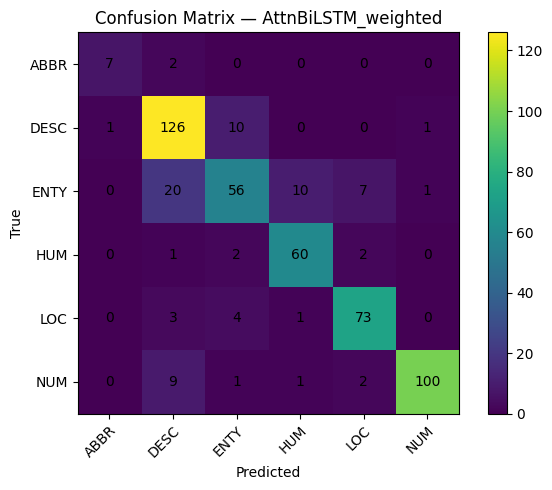

({'ABBR': 0.7777777777777778,
  'DESC': 0.9130434782608695,
  'ENTY': 0.6808510638297872,
  'HUM': 0.9384615384615385,
  'LOC': 0.8765432098765432,
  'NUM': 0.9026548672566371,
  'overall': 0.862},
 {'ABBR': 0.7777777777777778,
  'DESC': 0.9130434782608695,
  'ENTY': 0.5957446808510638,
  'HUM': 0.9230769230769231,
  'LOC': 0.9012345679012346,
  'NUM': 0.8849557522123894,
  'overall': 0.844})

In [9]:
# Targeted improvement: class weights (inverse frequency)
class_counts = train_df["label"].value_counts().reindex(labels).values
weights = 1.0 / torch.tensor(class_counts, dtype=torch.float)
weights = (weights / weights.sum()) * len(weights)

attn_bilstm_w = AttentiveBiLSTM(embedding_matrix, rnn_type="lstm",
                                num_classes=num_classes, pad_idx=PAD_IDX,
                                hidden_dim=128, num_layers=2)
attn_bilstm_w, _ = train_model(attn_bilstm_w, train_loader, val_loader,
                               epochs=EPOCHS, lr=LR, wd=WD,
                               class_weights=weights, tag="AttnBiLSTM_weighted")
acc_attn_w = test_model(attn_bilstm_w, test_loader, tag="AttnBiLSTM_weighted")
evaluate_per_class(attn_bilstm_w, test_loader, labels, tag="AttnBiLSTM_weighted")

topic_acc_attn   = topic_wise_accuracy(attn_bilstm,   test_loader)
topic_acc_weight = topic_wise_accuracy(attn_bilstm_w, test_loader)
topic_acc_attn, topic_acc_weight


In [10]:
# Summary
summary = pd.DataFrame({
    "Model": ["biLSTM","biGRU","CNN","AttnBiLSTM","AttnBiLSTM + weights"],
    "Test Acc": [acc_bilstm, acc_bigru, acc_cnn, acc_attn, acc_attn_w]
})
summary.to_csv(OUT/'summary_part3.csv', index=False)
summary


,Model,Test Acc
0,biLSTM,0.894
1,biGRU,0.878
2,CNN,0.902
3,AttnBiLSTM,0.862
4,AttnBiLSTM + weights,0.844
